<center><h1>SCI Classification </h1></center>

**Overview:** The below notebook explores the model tuning for two separate datasets related to the autonomic capacities of various spinal cord injuried (SCI) participants. The goal of this experiment is to classify the injury level of SCI participants as Tetra or Para. The first dataset examined, sci_all_tests, looks at 103 participants across 164 autonomic tests. The second dataset, sci_all_participants, explores 108 participants over 140 tests.

In [76]:
# import libraries to be used throughout project
import pandas as pd
import numpy as np
import matplotlib 
import math
from matplotlib import pylab as plt
import seaborn as sns

# import sci datasets for analysis
df_all_tests = pd.read_csv('../data/sci_all_tests.csv')
df_all_participants = pd.read_csv('../data/sci_all_participants.csv')

# drop ID column
df_all_tests.drop(['ID'],axis=1,inplace=True)
df_all_participants.drop(['ID'],axis=1,inplace=True)


<h2>SCI All Tests Model Tuning </h2>

In [77]:
df_all_tests.head()

,Group,OH_SBP,OH_DBP,V1_SV_Pre,V1_SV_Post,V1_SV_Diff,V2_SV_Pre,V2_SV_Post,V2_SV_Diff,SBP_BL_1_mean,...,vLF_VAL_2,SBP_HF_VAL_2,SBP_LF_VAL_2,SBP_vLF_VAL_2,alpha_HF_VAL_2,alpha_LF_VAL_2,avg_alpha_VAL_2,RR_VAR_VAL_2,RMSD_VAL_2,IBI_VAL_2
0,Tetra,5,7,8.00,20.00,12.00,8.00,20.00,12.00,117.8,...,473949.63,31.87,38.00,23476.35,2.76,3.14,2.95,5736.59,59.31,628.20
1,Tetra,5,6,16.48,27.22,10.74,16.48,27.22,10.74,110.2,...,754745.05,7.66,15.39,8091.98,6.15,8.50,7.32,4296.45,25.82,802.16
2,Tetra,0,0,11.19,33.95,22.76,11.23,29.78,18.55,119.2,...,970575.66,66.68,60.90,6357.35,24.06,10.69,17.37,95559.76,421.64,842.77
3,Tetra,0,3,13.03,28.36,15.33,13.03,28.36,15.33,119.8,...,353581.44,8.07,5.32,26708.02,3.55,8.34,5.95,1729.63,28.53,545.93
4,Para,0,0,8.00,20.00,12.00,8.00,18.00,10.00,97.8,...,669862.34,10.55,30.91,10407.12,4.90,5.70,5.30,2569.25,27.97,754.30


In [78]:
# create feature matrix and target vector 
y = df_all_tests['Group']
X = df_all_tests.loc[:,df_all_tests.columns != 'Group']
print('Count of datapoints:',X.shape[0])
print('Count of features:',X.shape[1])

Count of datapoints: 103
Count of features: 164


In [79]:
print('\nDatatype of each feature:')
# list datatypes for each feature
with pd.option_context('display.max_rows',None):
    print(df_all_tests.dtypes)


Datatype of each feature:
Group               object
OH_SBP               int64
OH_DBP               int64
V1_SV_Pre          float64
V1_SV_Post         float64
V1_SV_Diff         float64
V2_SV_Pre          float64
V2_SV_Post         float64
V2_SV_Diff         float64
SBP_BL_1_mean      float64
SBP_BL_1_std       float64
SBP_POS_1_mean     float64
SBP_POS_1_std      float64
SBP_ch_1_mean      float64
SBP_ch_1_std       float64
SBP_BL_2_mean      float64
SBP_BL_2_std       float64
SBP_POS_2_mean     float64
SBP_POS_2_std      float64
SBP_ch_2_mean      float64
SBP_ch_2_std       float64
DBP_BL_1_mean      float64
DBP_BL_1_std       float64
DBP_POS_1_mean     float64
DBP_POS_1_std      float64
DBP_ch_1_mean      float64
DBP_ch_1_std       float64
DBP_BL_2_mean      float64
DBP_BL_2_std       float64
DBP_POS_2_mean     float64
DBP_POS_2_std      float64
DBP_ch_2_mean      float64
DBP_ch_2_std       float64
HR_BL_1_mean       float64
HR_BL_1_std        float64
HR_POS_1_mean      float64
H

<h2>Preprocessing</h2>

In [112]:
# import needed libraries and preprocess the datasets 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# get list of features 
ftrs = X.columns

# initialize the preprocessor as columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ftrs),])

# create pipeline for preprocessor
pipe = Pipeline(steps=[('preprocessor', preprocessor)]) 

<h2>Model Tuning</h2>

In [81]:
# import libraries for model tuning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 

# calculate baseline accuracy 
all_tests_best_models = {}

baseline_pred = ['Para']*103

at_baseline_score = accuracy_score(y,baseline_pred)

print('Baseline score:',at_baseline_score)
y.value_counts()

Baseline score: 0.5825242718446602


Para     60
Tetra    43
Name: Group, dtype: int64

In [82]:
# general function to find best models and test scores 
def MLpipe_KFold_Acc(X,y,preprocessor,ml_algo,para_grid):
    # lists to hold best models and test scores      
    bestModels = []
    bestScores = np.zeros(10)
    bestParams = []
    XSets = []
    ySets = []
    
    # repeat process for 10 different random states
    for i in range(10):
        # split data into other and test
        X_other,X_test,y_other,y_test = train_test_split(X,y,random_state=i,train_size=0.8)
        
        # save the test sets 
        XSets.append(X_test)
        ySets.append(y_test)
        
        # initialize kfold splitter for other set
        kf = KFold(n_splits=4,shuffle=True,random_state=i)

        # create pipe for modeling and preprocesing
        pipe = make_pipeline(preprocessor,ml_algo)

        # create grid to loop through hyperparameter combinations and collect results
        grid = GridSearchCV(pipe,param_grid=para_grid,scoring='accuracy',cv=kf,
                            return_train_score=False,n_jobs=-1,verbose=False)

        # fit the model onto other
        grid.fit(X_other,y_other)

        results = pd.DataFrame(grid.cv_results_)
               
        bestParams.append(grid.best_params_)

        # save the model
        bestModels.append(grid)

        # calculate and save the test score
        y_test_pred = bestModels[-1].predict(X_test)
        bestScores[i] = accuracy_score(y_test,y_test_pred)

    
    return bestModels,bestScores, bestParams, XSets, ySets

<h3> Logistic Regression </h3>

In [83]:
# run l1 regularized linear regression to test your function in this cell
from sklearn.linear_model import LogisticRegression

# initialize model algo
log_mod = LogisticRegression(max_iter=10000,random_state=0)

# hyperparameters to tune
param_grid = {
              'logisticregression__C': np.logspace(-7,7,21) # the alpha value for regularization
              } 

# call function and save scores and models
log_bestModels, log_bestScores, log_bestParams, log_XSets,log_ySets = MLpipe_KFold_Acc(X,y,preprocessor,log_mod,param_grid)

# print('Number of Models:',len(log_bestModels))
# print('Number of Scores:',len(log_bestScores))

# print('\n')
# print(log_bestScores)

# print results
print('Average test score for logistic regression:',np.average(log_bestScores))
print('Standard deviation of test scores for logistic regression:', np.std(log_bestScores))

# save the best model test score
all_tests_best_models['Logistic Regression'] = np.round(np.average(log_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(log_bestParams)   
best_par

Average test score for logistic regression: 0.7285714285714285
Standard deviation of test scores for logistic regression: 0.04785655057676615

Best Parameters:


,logisticregression__C
0,0.039811
1,0.039811
2,0.007943
3,0.039811
4,0.039811
5,0.039811
6,0.007943
7,0.007943
8,0.039811
9,0.039811


<h3>Random Forest Classifier</h3>

In [84]:
# create random forest model
from sklearn.ensemble import RandomForestClassifier

# initialize model algo
RF_mod = RandomForestClassifier(random_state=0)

# hyperparameters to tune
param_grid = {
              'randomforestclassifier__max_depth': [1, 3, 5, 7, 10,15,20], # the max_depth of each tree
              'randomforestclassifier__max_features': [0.15, 0.25, 0.5,0.75,1.0], # linearly spaced between 0.5 and 1
#               'randomforestregressor__min_samples_leaf': np.logspace(1,100,21), # min number of samples on each leaf
              }  

# call function to generate models and store scores
RF1_bestModels, RF1_bestScores, RF1_bestParams, RF1_XSets,RF1_ySets = MLpipe_KFold_Acc(X,y,preprocessor,RF_mod,param_grid)

# print mean and std of test scores
print('Average test score for random forest:',np.average(RF1_bestScores))
print('Standard deviation of test scores for random forest:', np.std(RF1_bestScores))

# save the best model test score
all_tests_best_models['Random Forest'] = np.round(np.average(RF1_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(RF1_bestParams)  
best_par

Average test score for random forest: 0.7761904761904761
Standard deviation of test scores for random forest: 0.07079080355865955

Best Parameters:


,randomforestclassifier__max_depth,randomforestclassifier__max_features
0,1,1.00
1,1,0.25
2,1,0.25
3,1,0.25
4,1,0.50
5,3,0.75
6,5,0.25
7,1,0.25
8,1,0.15
9,3,0.15


<h3>Support Vector Classifier</h3>

In [85]:
# create SVC model
from sklearn.svm import SVC

# initialize model algo
SVC_mod = SVC()

# hyperparameters to tune
param_grid = {
              'svc__gamma': np.logspace(-4,3,15),
              'svc__C': np.logspace(-1,3,15)
              }  

# call function to generate models and store scores
SVC_bestModels, SVC_bestScores, SVC_bestParams,SVC_XSets,SVC_ySets = MLpipe_KFold_Acc(X,y,preprocessor,SVC_mod,param_grid)

# print mean and std of test scores
print('Average test score for SVC:',np.average(SVC_bestScores))
print('Standard deviation of test scores for SVC:', np.std(SVC_bestScores))

# save the best model test score
all_tests_best_models['SVC'] = np.round(np.average(SVC_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(SVC_bestParams)  
best_par

Average test score for SVC: 0.7
Standard deviation of test scores for SVC: 0.08261595987094034

Best Parameters:


,svc__C,svc__gamma
0,19.306977,0.000316
1,37.275937,0.000100
2,138.949549,0.000100
3,19.306977,0.001000
4,10.000000,0.003162
5,1.389495,0.003162
6,1.389495,0.003162
7,0.719686,0.010000
8,5.179475,0.003162
9,1.389495,0.003162


<h3>K-Nearest Neighbors</h3>

In [86]:
# create Nearest Neighbor model
from sklearn.neighbors import KNeighborsClassifier
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

# initialize model algo
k_mod = KNeighborsClassifier()

# hyperparameters to tune
param_grid = {
              'kneighborsclassifier__n_neighbors': [1,10,15,20,30], # amount of neighbors to use 
              'kneighborsclassifier__weights': ['uniform','distance'] # type of weight to consider
              }  

# call function to generate models and store scores
k_bestModels, k_bestScores, k_bestParams, k_XSets,k_ySets = MLpipe_KFold_Acc(X,y,preprocessor,k_mod,param_grid)

# print mean and std of test scores
print('Average test score for K-Nearest Neighbor:',np.average(k_bestScores))
print('Standard deviation of test scores for K-Nearest Neighbor:', np.std(k_bestScores))

# save the best model test score
all_tests_best_models['KNN'] = np.round(np.average(k_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(k_bestParams)  
best_par

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

Average test score for K-Nearest Neighbor: 0.6571428571428573
Standard deviation of test scores for K-Nearest Neighbor: 0.10389249632986396

Best Parameters:


/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

,kneighborsclassifier__n_neighbors,kneighborsclassifier__weights
0,15,uniform
1,10,distance
2,1,uniform
3,10,distance
4,15,distance
5,10,distance
6,10,distance
7,1,uniform
8,10,distance
9,10,distance


<h3>XGBoost Classifier Tuning</h3>

In [87]:
# import needed libraries
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
import warnings
warnings.filterwarnings("ignore")

# random states to tune with
seeds = [5,15,25,35,45,60,79]
alphas = [0e0, 1e-2, 1e-1, 1e0, 1e1]
learning = [1e-1,2e-1,3e-1,4e-1,5e-1]

# parameter grid for model tuning     
grid = {
    "reg_alpha": alphas,
    "learning_rate":learning
   }

# list to save best test scores, all test sets, and best models  
test_scores = []
test_sets = []
y_sets = []
best_models = []

# create models for the 5 different random states 
for seed in seeds:
    # lists to save validation and test scores, and the best models and test sets 
    val_scores = []
    all_models = []
    all_test_scores = []
    
    # split the data into train,val,and test using random seed
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size=0.6,random_state=seed,stratify=y)
    X_val,X_test,y_val,y_test = train_test_split(X_other,y_other,test_size=0.5,random_state=seed,stratify=y_other)
    
    # fit the preprocessor to the train data and transform train, val, and test    
    X_train_prep = pipe.fit_transform(X_train)
    X_val_prep = pipe.transform(X_val)
    X_test_prep = pipe.transform(X_test)
    
    # save test sest into list
    test_sets.append(X_test_prep)
    y_sets.append(y_test)
    
    # loop through and tune alphas
    for j in range(len(alphas)):
        # initialize and set the alpha for xgboost         
        XGB = xgboost.XGBClassifier()
        XGB.set_params(**ParameterGrid(grid)[j])
        
        # fit model to the train data, evaluate on the validation set         
        XGB.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)],
                verbose=False,eval_metric='logloss')
        
        # predict the validation and test variables          
        y_val_pred = XGB.predict(X_val_prep)
        y_test_pred = XGB.predict(X_test_prep)
        
        # add validation and test scores to list          
        val_scores.append(accuracy_score(y_val,y_val_pred))
        all_test_scores.append(accuracy_score(y_test,y_test_pred))
        # add all models to list, will tune down to best_models outside hyper loop 
        all_models.append(XGB)
        
    # find index of best validation score 
    index = np.argmax(val_scores)
    test_scores.append(all_test_scores[index])
    best_models.append(all_models[index])
    
# print(test_scores)
# print(best_models)

print('Mean of the test scores:',np.average(test_scores))
print('Standard deviation of the test scores:',np.std(test_scores))

# save the best model test score
all_tests_best_models['XGBoost'] = np.round(np.average(test_scores),decimals = 3)


Mean of the test scores: 0.7414965986394558
Standard deviation of the test scores: 0.043024185852631014


<h3>Test Results</h3>

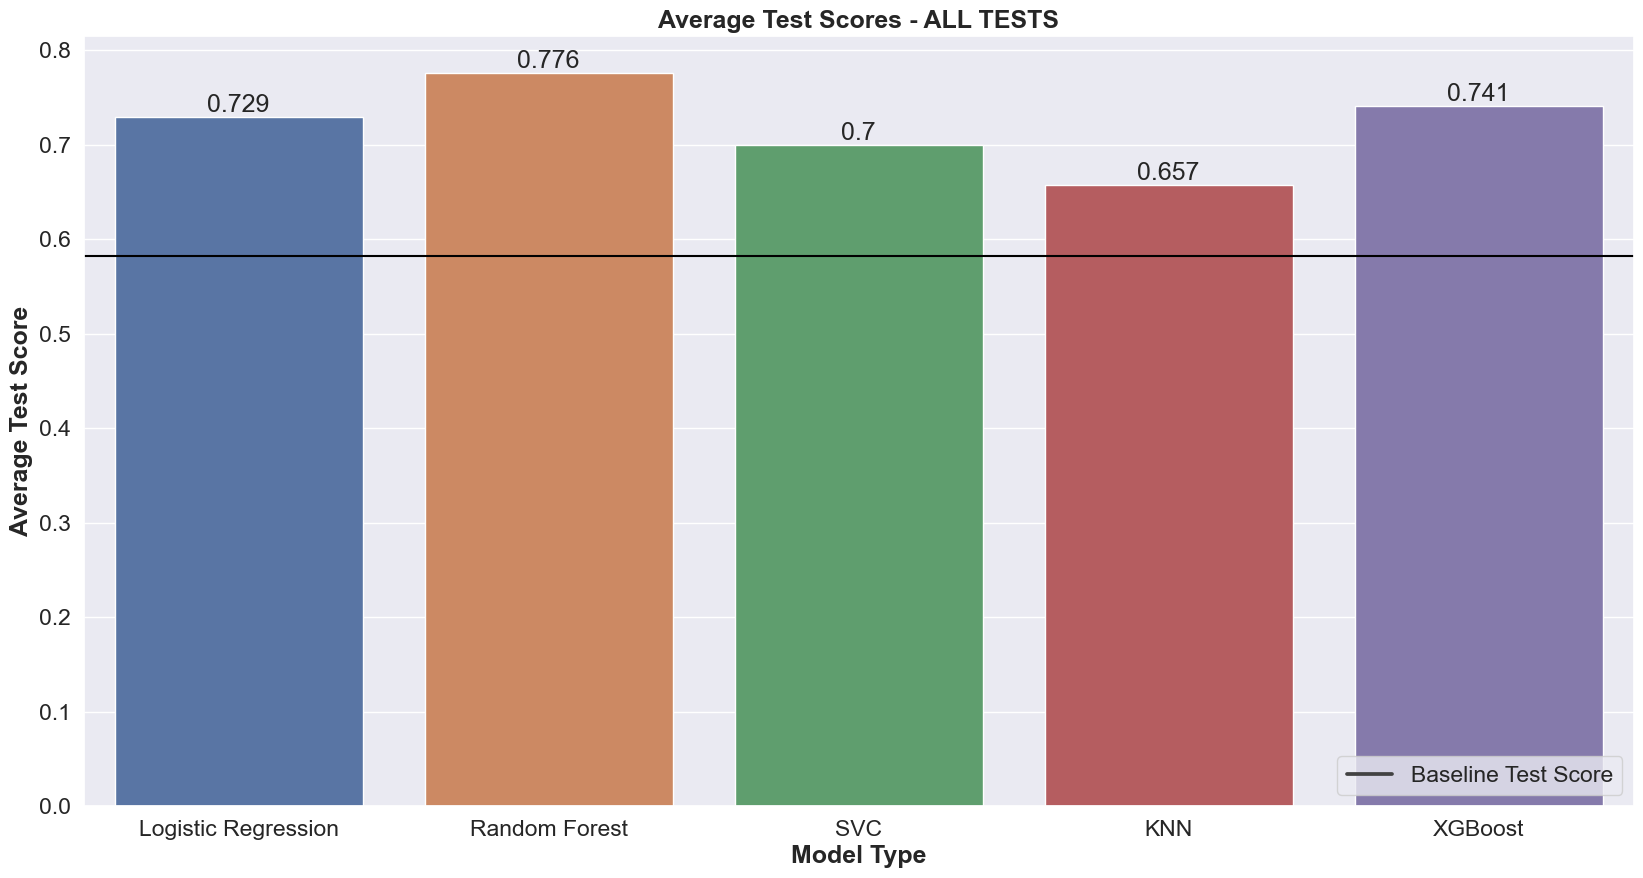

In [88]:
sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=4
sns.set(font_scale=1.5)

at = pd.DataFrame(list(all_tests_best_models.items()),columns=['Model Type','Average Test Score'])
graph = sns.barplot(x="Model Type",y="Average Test Score",data=at)
plt.bar_label(graph.containers[0],size=18)

#Drawing a horizontal line at point 1.25
graph.axhline(at_baseline_score,color='black')

# label plot
plt.legend(labels = ['Baseline Test Score'],loc='lower right')
plt.title('Average Test Scores - ALL TESTS',weight='bold')
plt.xlabel('Model Type',weight='bold')
plt.ylabel('Average Test Score',weight='bold')

#The plot is shown
plt.savefig(fname='../figures/all_tests_models',format='png',dpi=300)
plt.show()

<h2>SCI All Participants Model Tuning </h2>

In [89]:
df_all_participants.head()

,Group,OH_SBP,OH_DBP,V1_SV_Pre,V1_SV_Post,V1_SV_Diff,V2_SV_Pre,V2_SV_Post,V2_SV_Diff,SBP_BL_1_mean,...,V2_vLF_DB,V2_SBP_HF_DB,V2_SBP_LF_DB,V2_SBP_vLF_DB,V2_alpha_HF_DB,V2_alpha_LF_DB,V2_avg_alpha_DB,V2_RR_VAR_DB,V2_RMSD_DB,V2_IBI_DB
0,Tetra,5,7,8.00,20.00,12.00,8.00,20.00,12.00,117.8,...,419379.53,24.80,53.64,26371.32,1.83,2.44,2.14,2373.00,26.68,615.95
1,Para,0,2,13.03,27.11,14.08,13.09,25.59,12.50,143.2,...,989603.90,31.91,45.63,107.30,2.71,9.01,5.86,3974.26,28.16,924.91
2,Para,0,9,13.19,30.29,17.10,13.32,28.57,15.25,136.8,...,866983.55,1.37,45.25,10924.33,5.77,3.93,4.85,1513.52,13.81,857.91
3,Para,1,2,13.21,26.65,13.44,13.55,26.40,12.85,113.4,...,746316.77,1.09,66.15,22861.51,22.50,12.21,17.36,7286.49,60.99,806.41
4,Para,0,1,13.27,26.97,13.70,12.55,26.85,14.30,105.8,...,738151.78,1.28,90.05,22257.26,32.33,11.90,22.11,7810.70,63.30,791.65


In [90]:
# create feature matrix and target vector 
y = df_all_participants['Group']
X = df_all_participants.loc[:,df_all_participants.columns != 'Group']
print('Count of datapoints:',X.shape[0])
print('Count of features:',X.shape[1])

Count of datapoints: 108
Count of features: 140


<h3>Preprocessing</h3>

In [155]:
# get list of features 
ftrs = X.columns

# initialize the preprocessor as columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ftrs),])

# create pipeline for preprocessor
pipe = Pipeline(steps=[('preprocessor', preprocessor)]) 

<h3>Model Tuning </h3>

In [92]:
# calculate baseline accuracy 

# dictionary for test scores 
all_part_best_models = {}

baseline_pred = ['Para']*108

ap_baseline_score = accuracy_score(y,baseline_pred)

print('Baseline score:',ap_baseline_score)
y.value_counts()

Baseline score: 0.5925925925925926


Para     64
Tetra    44
Name: Group, dtype: int64

<h3>Logistic Regression</h3>

In [93]:
# initialize model algo
log_mod = LogisticRegression(max_iter=10000,random_state=0)

# hyperparameters to tune
param_grid = {
              'logisticregression__C': np.logspace(-7,7,21) # the alpha value for regularization
              } 

# call function and save scores and models
log_bestModels, log_bestScores, log_bestParams, log_XSets,log_ySets = MLpipe_KFold_Acc(X,y,preprocessor,log_mod,param_grid)

# print('Number of Models:',len(log_bestModels))
# print('Number of Scores:',len(log_bestScores))

# print('\n')
# print(log_bestScores)

# print results
print('Average test score for logistic regression:',np.average(log_bestScores))
print('Standard deviation of test scores for logistic regression:', np.std(log_bestScores))

# save the best model test score
all_part_best_models['Logistic Regression'] = np.round(np.average(log_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(log_bestParams)   
best_par

Average test score for logistic regression: 0.7999999999999999
Standard deviation of test scores for logistic regression: 0.10405021038417817

Best Parameters:


,logisticregression__C
0,0.039811
1,0.039811
2,0.199526
3,0.199526
4,0.039811
5,0.039811
6,0.007943
7,0.007943
8,0.007943
9,398107.170553


<h3>Random Forest </h3>

In [157]:
# initialize model algo
RF_mod = RandomForestClassifier(random_state=0)

# hyperparameters to tune
param_grid = {
              'randomforestclassifier__max_depth': [1, 3, 5, 7, 10,15,20], # the max_depth of each tree
              'randomforestclassifier__max_features': [0.15, 0.25, 0.5,0.75,1.0], # linearly spaced between 0.5 and 1
#               'randomforestregressor__min_samples_leaf': np.logspace(1,100,21), # min number of samples on each leaf
              }  

# call function to generate models and store scores
RF2_bestModels, RF2_bestScores, RF2_bestParams, RF2_XSets, RF2_ySets = MLpipe_KFold_Acc(X,y,preprocessor,RF_mod,param_grid)

# print mean and std of test scores
print('Average test score for random forest:',np.average(RF2_bestScores))
print('Standard deviation of test scores for random forest:', np.std(RF2_bestScores))

# save the best model test score
all_part_best_models['Random Forest'] = np.round(np.average(RF2_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(RF2_bestParams)  
best_par

Average test score for random forest: 0.840909090909091
Standard deviation of test scores for random forest: 0.09147550817044597

Best Parameters:


,randomforestclassifier__max_depth,randomforestclassifier__max_features
0,1,0.15
1,1,0.25
2,1,0.15
3,5,0.25
4,1,0.15
5,3,0.15
6,1,0.15
7,5,0.25
8,3,0.50
9,5,0.50


<h3>Support Vector Classifier</h3>

In [95]:
# initialize model algo
SVC_mod = SVC()

# hyperparameters to tune
param_grid = {
              'svc__gamma': np.logspace(-4,3,15),
              'svc__C': np.logspace(-1,3,15)
              }  

# call function to generate models and store scores
SVC_bestModels, SVC_bestScores, SVC_bestParams, SVC_XSets, SVC_ySets = MLpipe_KFold_Acc(X,y,preprocessor,SVC_mod,param_grid)

# print mean and std of test scores
print('Average test score for SVC:',np.average(SVC_bestScores))
print('Standard deviation of test scores for SVC:', np.std(SVC_bestScores))

# save the best model test score
all_part_best_models['SVC'] = np.round(np.average(SVC_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(SVC_bestParams)  
best_par

Average test score for SVC: 0.759090909090909
Standard deviation of test scores for SVC: 0.09326492967583269

Best Parameters:


,svc__C,svc__gamma
0,1.389495,0.003162
1,2.682696,0.003162
2,19.306977,0.000316
3,5.179475,0.001000
4,1.389495,0.003162
5,2.682696,0.001000
6,2.682696,0.001000
7,37.275937,0.000100
8,1.389495,0.003162
9,5.179475,0.010000


<h3>K-Nearest Neighbors</h3>

In [96]:
# initialize model algo
k_mod = KNeighborsClassifier()

# hyperparameters to tune
param_grid = {
              'kneighborsclassifier__n_neighbors': [1,10,15,20,30], # amount of neighbors to use 
              'kneighborsclassifier__weights': ['uniform','distance'] # type of weight to consider
              }  

# call function to generate models and store scores
k_bestModels, k_bestScores, k_bestParams, k_XSets,k_ySets = MLpipe_KFold_Acc(X,y,preprocessor,k_mod,param_grid)

# print mean and std of test scores
print('Average test score for K-Nearest Neighbor:',np.average(k_bestScores))
print('Standard deviation of test scores for K-Nearest Neighbor:', np.std(k_bestScores))

# save the best model test score
all_part_best_models['KNN'] = np.round(np.average(k_bestScores),decimals = 3)

print('\nBest Parameters:')
best_par = pd.DataFrame(k_bestParams)  
best_par

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

Average test score for K-Nearest Neighbor: 0.6636363636363637
Standard deviation of test scores for K-Nearest Neighbor: 0.11171096115858643

Best Parameters:


/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

,kneighborsclassifier__n_neighbors,kneighborsclassifier__weights
0,15,uniform
1,10,distance
2,10,distance
3,1,uniform
4,10,distance
5,10,uniform
6,15,uniform
7,15,uniform
8,1,uniform
9,1,uniform


<h3>XGBoost Classifier</h3>

In [97]:
# random states to tune with
seeds = [5,15,25,35,45,60,79]
alphas = [0e0, 1e-2, 1e-1, 1e0, 1e1]
learning = [1e-1,2e-1,3e-1,4e-1,5e-1]

# parameter grid for model tuning     
grid = {
    "reg_alpha": alphas,
    "learning_rate":learning
   }

# list to save best test scores, all test sets, and best models  
test_scores = []
test_sets = []
y_sets = []
best_models = []

# create models for the 5 different random states 
for seed in seeds:
    # lists to save validation and test scores, and the best models and test sets 
    val_scores = []
    all_models = []
    all_test_scores = []
    
    # split the data into train,val,and test using random seed
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size=0.6,random_state=seed,stratify=y)
    X_val,X_test,y_val,y_test = train_test_split(X_other,y_other,test_size=0.5,random_state=seed,stratify=y_other)
    
    # fit the preprocessor to the train data and transform train, val, and test    
    X_train_prep = pipe.fit_transform(X_train)
    X_val_prep = pipe.transform(X_val)
    X_test_prep = pipe.transform(X_test)
    
    # save test sest into list
    test_sets.append(X_test_prep)
    y_sets.append(y_test)
    
    # loop through and tune alphas
    for j in range(len(alphas)):
        # initialize and set the alpha for xgboost         
        XGB = xgboost.XGBClassifier()
        XGB.set_params(**ParameterGrid(grid)[j])
        
        # fit model to the train data, evaluate on the validation set         
        XGB.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)],
                verbose=False,eval_metric='logloss')
        
        # predict the validation and test variables          
        y_val_pred = XGB.predict(X_val_prep)
        y_test_pred = XGB.predict(X_test_prep)
        
        # add validation and test scores to list          
        val_scores.append(accuracy_score(y_val,y_val_pred))
        all_test_scores.append(accuracy_score(y_test,y_test_pred))
        # add all models to list, will tune down to best_models outside hyper loop 
        all_models.append(XGB)
        
    # find index of best validation score 
    index = np.argmax(val_scores)
    test_scores.append(all_test_scores[index])
    best_models.append(all_models[index])
    
# print(test_scores)
# print(best_models)

print('Mean of the test scores:',np.average(test_scores))
print('Standard deviation of the test scores:',np.std(test_scores))

# save the best model test score
all_part_best_models['XGBoost'] = np.round(np.average(test_scores),decimals = 3)

Mean of the test scores: 0.8181818181818181
Standard deviation of the test scores: 0.04859295307498625


<h2>Test Results</h2>

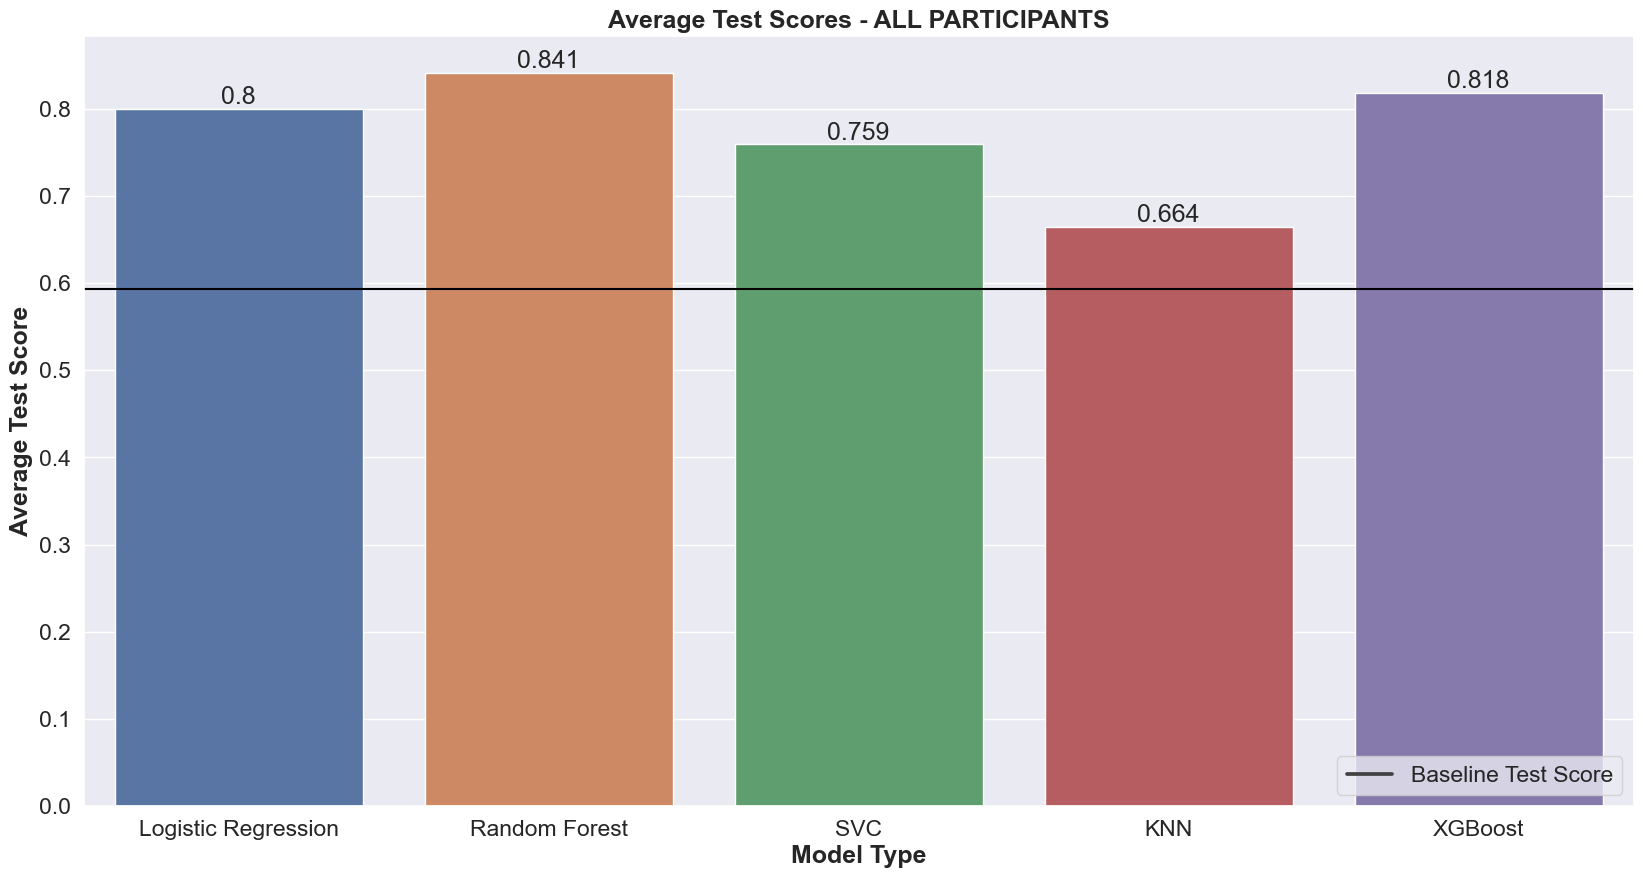

In [98]:
sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=4
sns.set(font_scale=1.5)

ap = pd.DataFrame(list(all_part_best_models.items()),columns=['Model Type','Average Test Score'])
graph = sns.barplot(x="Model Type",y="Average Test Score",data=ap)
plt.bar_label(graph.containers[0],size=18)

#Drawing a horizontal line at point 1.25
graph.axhline(ap_baseline_score,color='black')

# label plot
plt.legend(labels = ['Baseline Test Score'],loc='lower right')
plt.title('Average Test Scores - ALL PARTICIPANTS',weight='bold')
plt.xlabel('Model Type',weight='bold')
plt.ylabel('Average Test Score',weight='bold')

#The plot is shown
plt.savefig(fname='../figures/all_part_models',format='png',dpi=300)
plt.show()

<h2>Dataset Comparison</h2>

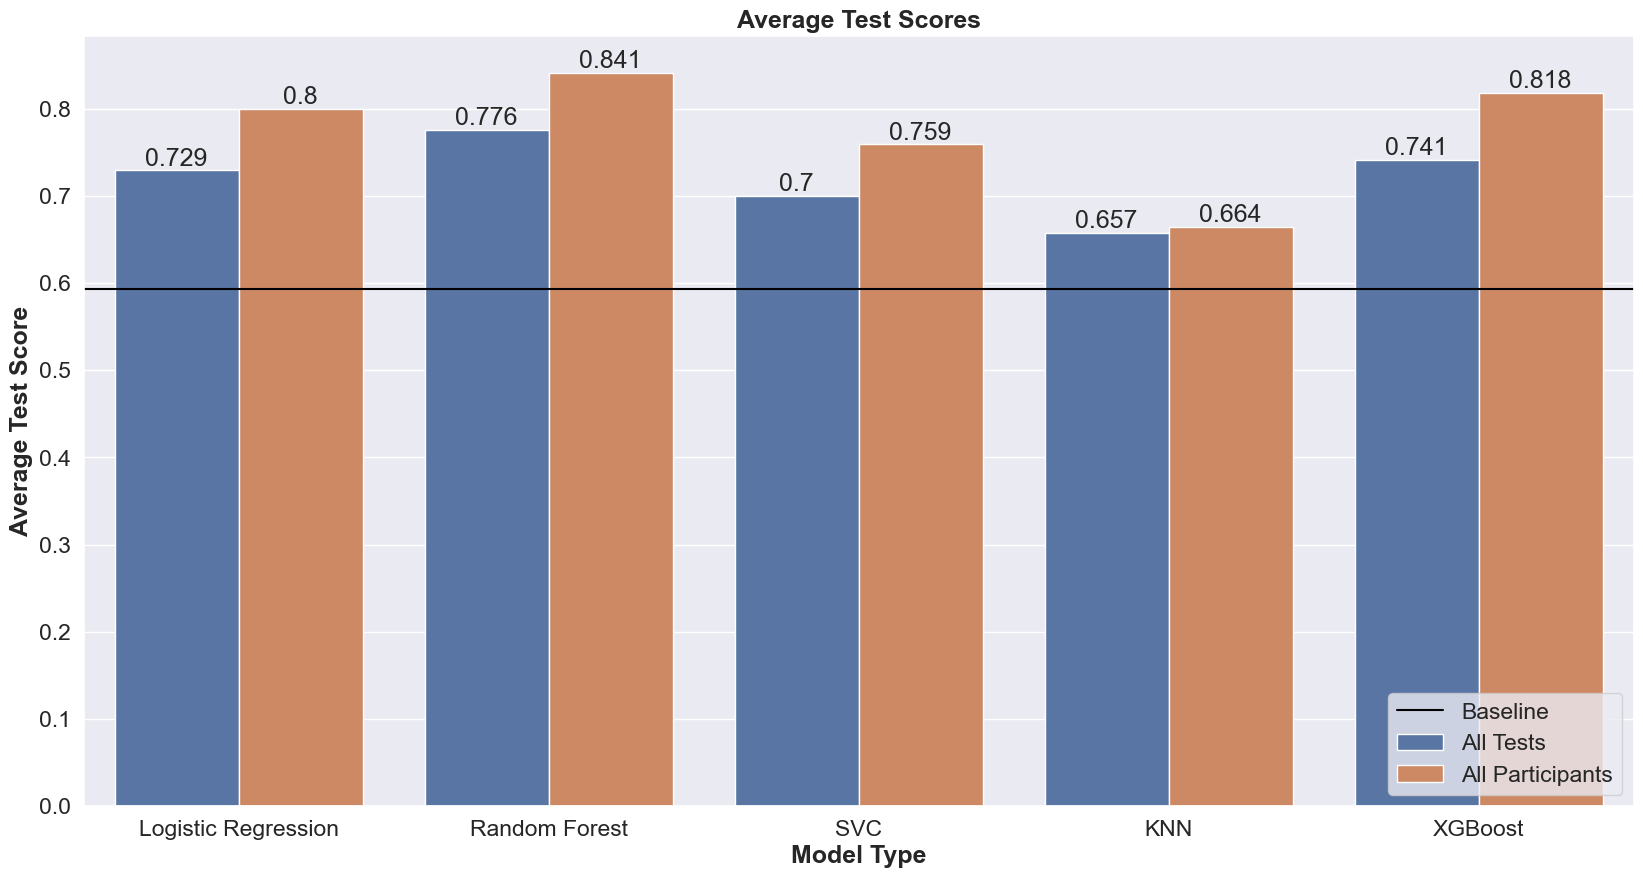

In [99]:
df_list = [at,ap]
tot_df = pd.concat(df_list)
tot_df['data'] = ['All Tests','All Tests','All Tests','All Tests','All Tests',
                  'All Participants','All Participants','All Participants','All Participants','All Participants']
graph = sns.barplot(x="Model Type",y="Average Test Score",hue='data',data=tot_df)
plt.bar_label(graph.containers[0],size=18)
plt.bar_label(graph.containers[1],size=18)
#Drawing a horizontal line at point 1.25
graph.axhline(ap_baseline_score,color='black',label='Baseline')

# label plot
# plt.legend(labels = ['Baseline Test Score'],loc='lower right')
plt.title('Average Test Scores',weight='bold')
plt.xlabel('Model Type',weight='bold')
plt.ylabel('Average Test Score',weight='bold')
plt.legend(loc='lower right')

#The plot is shown
plt.savefig(fname='../figures/all_models',format='png',dpi=300)
plt.show()

**Analysis Breakdown:** The above plot illustrates the average test score across all models for both of the SCI dataframes. From the plot we can observe that the all_participants dataset performs better than the all_tests dataset for each of the models. This conclusion reinforces the idea that more datapoints, as opposed to more features, are needed to enhance the predictive power of these models. Collecting additional data on more patients may help to further boost our test scores. The Random Forest classifier was the most predictive model for both datasets. Further analysis must be performed to determine the relative feature importances used to make the model's predictions.